In [1]:
import os 
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

/srv/ds_project/Indra_proj/dsp_gamification_experiment


In [2]:
# Import modules 

import os 
import itertools
from IPython.display import display

from credential_accessor import CredentialAccessor 
from dao.google_bigquery import GoogleBigQuery as gbq 

creds_accessor = CredentialAccessor(env = "prod", on_server= False)
myGBQ = gbq(attr = creds_accessor.get_attr())


from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

import json

import joblib 


import pandas as pd 
import numpy as np 


import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('bmh')
%matplotlib inline

In [3]:
END_DATE_QUIZ = "2024-04-29"
END_DATE_SUBMIT = "2024-04-28"
START_DATE = "2024-04-01"
PARETO_DATE_STR = "04/01/2024"
PARETO_DATE = "2024-04-01"

In [14]:
query_raw = """
select 
res.cluster , 
res.mitra_group_id, 
res.mitra_id , 
res.quiz_id, 
res.prd_id,
res.assortment_flag,
mmmp.prd_name,
res.result, 
res.submited_at
from mp_mst.mp_mst_gamification_result_details res
left join mp_mst.mp_mst_master_products mmmp on mmmp.prd_id = res.prd_id
where res.submited_at is not null and date(res.submited_at) <= "{end_date}"
group by 1,2,3,4,5,6,7,8,9
order by 1,2,3,9,4,5
"""

df_raw = myGBQ.gbq_read(query=query_raw.format(end_date = END_DATE_SUBMIT)) 
df_raw['quiz_mitra_id'] = df_raw['quiz_id'] + "_" + df_raw['mitra_id'].astype(str)
# df_raw['cluster'] = df_raw.cluster.apply(lambda x : 'PRIANGAN TIMUR' if x in ('PRIANGAN TIMUR 2','PRIANGAN TIMUR 1') else x)
df_raw

,cluster,mitra_group_id,mitra_id,quiz_id,prd_id,assortment_flag,prd_name,result,submited_at,quiz_mitra_id
0,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,261,True,Dangke 40WP 100gr,False,2024-04-18 11:00:40,BANDUNG RAYA_20240401_24_01_39540
1,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,2419,False,Sidatan XR 525SL 400ml,False,2024-04-18 11:00:40,BANDUNG RAYA_20240401_24_01_39540
2,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,24714,False,Pupuk Phonska 50kg,False,2024-04-18 11:00:40,BANDUNG RAYA_20240401_24_01_39540
3,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_02,1236,False,Folicur Gold 430SC 240ml,False,2024-04-18 11:00:44,BANDUNG RAYA_20240401_24_02_39540
4,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_02,4424,True,Bulir G Umbi-umbian 500gr,False,2024-04-18 11:00:44,BANDUNG RAYA_20240401_24_02_39540
...,...,...,...,...,...,...,...,...,...,...
59791,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_03,11069,False,Amandy 865SL 200ml,True,2024-04-22 15:25:08,PRIANGAN TIMUR 2_20240401_14_03_34474
59792,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_03,17024,False,DMA 6 825SL 20x400ml 1Box,False,2024-04-22 15:25:08,PRIANGAN TIMUR 2_20240401_14_03_34474
59793,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_04,130,False,Serendy 28WP 25gr,True,2024-04-22 15:25:11,PRIANGAN TIMUR 2_20240401_14_04_34474
59794,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_04,5691,False,CBA-6 865SL 200ml,True,2024-04-22 15:25:11,PRIANGAN TIMUR 2_20240401_14_04_34474


In [15]:
print(f"Null values at raw table :")
pd.isna(df_raw).sum(axis=0)

Null values at raw table :


cluster            0
mitra_group_id     0
mitra_id           0
quiz_id            0
prd_id             0
assortment_flag    0
prd_name           0
result             0
submited_at        0
quiz_mitra_id      0
dtype: int64

Number of mitra in each mitra_group

In [16]:
query_mitra_group_num = """
select cluster, mitra_group_id,count(distinct mitra_id) num_of_mitra
from mp_ref.mp_ref_gamification_mitra_group_details 
where pareto_snapshot_dt = "{pareto_date}"
group by 1,2
"""

df_num_mitra_per_group = myGBQ.gbq_read(query_mitra_group_num.format(pareto_date = PARETO_DATE))
print("Average mitra per group / batch in each cluster")
df_num_mitra_per_group.groupby('cluster').num_of_mitra.mean()
# print(

Average mitra per group / batch in each cluster


cluster
BANDUNG RAYA            43.24
BOCIMI              68.363636
CIAYUMAJAKUNING     60.041667
KAPURSUB               53.875
PRIANGAN TIMUR 1    26.121212
PRIANGAN TIMUR 2    57.823529
Name: num_of_mitra, dtype: Float64

In [17]:
query_total_quiz = """
with tab_mg as (
select cluster, mitra_group_id, quiz_id 
from mp_ref.mp_ref_gamification_mitra_group_quiz_mapping mg
where date(mg.pareto_snapshot_dt) = "{pareto_date}" and date(mg.quiz_end_date) <= "{end_date_quiz}"
group by 1,2,3
),

tab_final as (
select  mgd.cluster, mgd.mitra_group_id, mgd.mitra_id, tab_mg.quiz_id
from mp_ref.mp_ref_gamification_mitra_group_details  mgd
left join tab_mg on tab_mg.mitra_group_id = mgd.mitra_group_id and tab_mg.cluster = mgd.cluster
where date(mgd.pareto_snapshot_dt) = "{pareto_date}" 
group by 1,2,3,4),

tab_mtu as (
select v2v.cluster, count(distinct mmod.mitra_id) mtu 
from mp_mst.mp_mst_order_details mmod 
left join mp_bi.mp_bi_fact_mitra_v2v v2v on v2v.mitra_id = mmod.mitra_id 
where mmod.trx_status = "COMPLETED" and date(mmod.trx_created_at) >= "{start_date}" and date(mmod.trx_created_at) <= "{end_date}"
and v2v.province = "JAWA BARAT" and v2v.cluster is not null
group by 1
)



select tab_final.cluster, tab_mtu.mtu total_mtu,count(distinct mitra_id) total_mitra,count(distinct concat(quiz_id,'_',mitra_id)) total_quiz
from tab_final
left join tab_mtu on tab_mtu.cluster = tab_final.cluster
group by 1,2

"""

df_total_quiz_agg = myGBQ.gbq_read(query_total_quiz.format(start_date = START_DATE, end_date_quiz = END_DATE_QUIZ, end_date = END_DATE_SUBMIT, pareto_date = PARETO_DATE))

df_choosen_quiz_agg = df_raw.groupby(['cluster'],as_index=False).agg(quiz_done = ('quiz_mitra_id','nunique'), mitra_done = ('mitra_id','nunique'))
df_total_quiz_agg = df_total_quiz_agg.merge(df_choosen_quiz_agg,how='left',on=['cluster'])
df_total_quiz_agg['quiz_done_pct'] = df_total_quiz_agg['quiz_done']*100/df_total_quiz_agg['total_quiz']
df_total_quiz_agg['mitra_done_pct'] = df_total_quiz_agg['mitra_done']*100/df_total_quiz_agg['total_mitra']
df_total_quiz_agg['mtu_done_pct'] = df_total_quiz_agg['mitra_done']*100/df_total_quiz_agg['total_mtu']
print(f"Total mitra done : {df_total_quiz_agg.mitra_done.sum()}")
df_total_quiz_agg

Total mitra done : 506


,cluster,total_mtu,total_mitra,total_quiz,quiz_done,mitra_done,quiz_done_pct,mitra_done_pct,mtu_done_pct
0,PRIANGAN TIMUR 2,<NA>,983,109634,1360,36,1.240491,3.662258,<NA>
1,BOCIMI,253,1504,168448,5511,122,3.271633,8.111702,48.221344
2,KAPURSUB,328,1293,142236,3340,87,2.34821,6.728538,26.52439
3,BANDUNG RAYA,288,1081,120372,3767,115,3.129465,10.638298,39.930556
4,CIAYUMAJAKUNING,299,1441,157054,3343,86,2.128567,5.968078,28.762542
5,PRIANGAN TIMUR 1,<NA>,862,95474,2611,60,2.734776,6.960557,<NA>


In [18]:
import io
def paste_df_str(df : pd.DataFrame, *args, **kwargs) : 
    with io.StringIO() as buffer:
        df.to_csv(buffer, sep=',', index=False)
        return buffer.getvalue()
print(paste_df_str(df_total_quiz_agg))

cluster,total_mtu,total_mitra,total_quiz,quiz_done,mitra_done,quiz_done_pct,mitra_done_pct,mtu_done_pct
PRIANGAN TIMUR 2,,983,109634,1360,36,1.2404910885309302,3.6622583926754833,
BOCIMI,253,1504,168448,5511,122,3.2716327887537995,8.111702127659575,48.22134387351779
KAPURSUB,328,1293,142236,3340,87,2.3482100171545883,6.728538283062645,26.524390243902438
BANDUNG RAYA,288,1081,120372,3767,115,3.129465324161765,10.638297872340425,39.93055555555556
CIAYUMAJAKUNING,299,1441,157054,3343,86,2.128567244387281,5.968077723802915,28.762541806020067
PRIANGAN TIMUR 1,,862,95474,2611,60,2.7347759599472106,6.960556844547564,



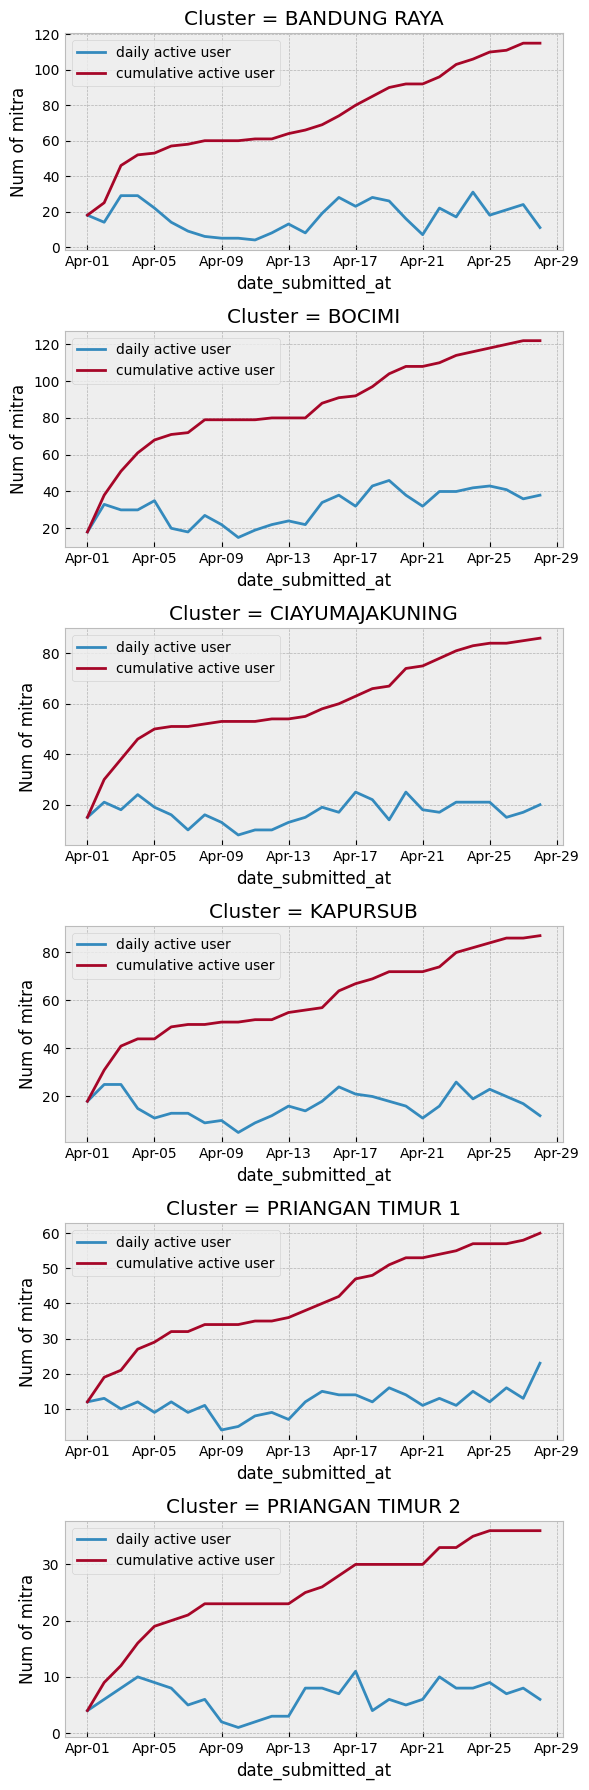

In [19]:
timeline_mitra = df_raw[['cluster','mitra_id','quiz_id','submited_at']].copy()
timeline_mitra['submited_at'] =timeline_mitra['submited_at'].dt.date
timeline_mitra = timeline_mitra.drop_duplicates(subset=['cluster','mitra_id','quiz_id'],keep='first').sort_values(['cluster','mitra_id','submited_at'])
timeline_mitra['rank_day'] = timeline_mitra.groupby(['mitra_id'],sort=False).mitra_id.rank(method='first')

fig, ax = plt.subplots(df_raw.cluster.unique().shape[0],1,figsize=(6,18))
for idx,cluster_ in enumerate(df_raw.cluster.unique()) : 
    not_cum_mitra = timeline_mitra[timeline_mitra.cluster==cluster_].groupby('submited_at',as_index=False).mitra_id.nunique()
    not_cum_mitra.plot.line(x='submited_at',y='mitra_id',ax=ax[idx],label='daily active user')
    cum_mitra = timeline_mitra[(timeline_mitra.cluster==cluster_) & (timeline_mitra.rank_day==1)].groupby('submited_at',as_index=False).mitra_id.nunique()
    cum_mitra['cumsum'] = cum_mitra.mitra_id.cumsum()
    not_cum_mitra = not_cum_mitra.merge(cum_mitra,how='left',on='submited_at')
    not_cum_mitra['cumsum'] = not_cum_mitra['cumsum'].fillna(method='ffill')
    not_cum_mitra.plot.line(x='submited_at',y='cumsum',ax=ax[idx],label='cumulative active user')
    ax[idx].set_title(f'Cluster = {cluster_}')
    ax[idx].set_xlabel('date_submitted_at')
    ax[idx].set_ylabel('Num of mitra')
    ax[idx].legend().set_visible(True)
    date_form = mpl.dates.DateFormatter("%b-%d")
    ax[idx].xaxis.set_major_formatter(date_form)
    # ax[idx].set_axisbelow(True)
plt.tight_layout()
fig.savefig('test.svg',dpi=1000)

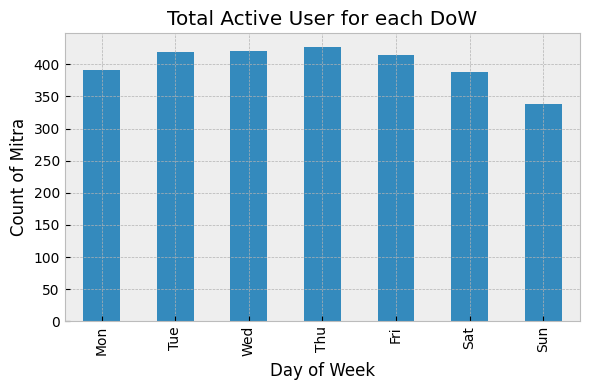

In [20]:
fig,ax = plt.subplots(figsize=(6,4))

timeline_mitra['dow'] = timeline_mitra['submited_at'].apply(lambda x:x.weekday())
timeline_mitra['mitra_submited_at'] = timeline_mitra['mitra_id'].astype(str) + "_" + timeline_mitra['submited_at'].astype(str)
day_agg = timeline_mitra.groupby('dow').mitra_submited_at.nunique()
day_agg.plot.bar(ax=ax)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_title('Total Active User for each DoW')
ax.set_ylabel('Count of Mitra')
ax.set_xlabel('Day of Week')
plt.tight_layout()
fig.savefig('test.svg',dpi=1000)    
    

Text(0, 0.5, 'Num of Quiz')

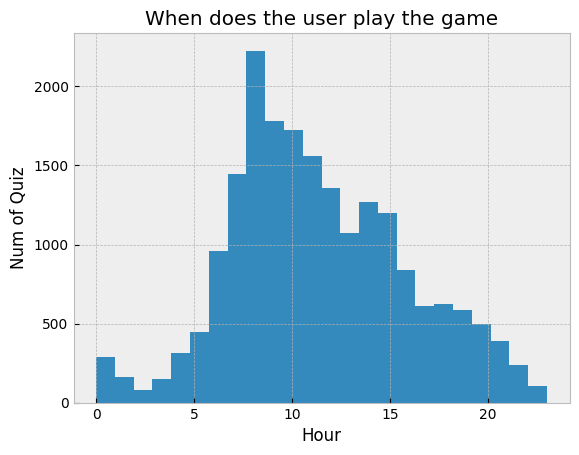

In [21]:
hour = df_raw[['cluster','mitra_id','quiz_id','submited_at']].copy()
hour = hour.drop_duplicates(subset = ['cluster','mitra_id','quiz_id'],keep='first')
hour['hour'] = hour.submited_at.dt.hour
fig,ax = plt.subplots()
hour['hour'].plot.hist(bins=24)
ax.set_xlabel('Hour')
ax.set_title("When does the user play the game")
ax.set_ylabel('Num of Quiz')

In [22]:
cohort_val = np.zeros((4,4))
cohort_pct = np.zeros((4,4))
for week_base in range(4) : 
    start_date_base = (datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=week_base)).date()
    end_date_base = (datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=week_base+1)).date()
    print(f"base : {start_date_base} - {end_date_base}")
    pool_mitra = timeline_mitra[(timeline_mitra.rank_day==1) & (timeline_mitra.submited_at >= start_date_base) & (timeline_mitra.submited_at < end_date_base)]
    base_value = pool_mitra.mitra_id.nunique()
    print(base_value)
    for week_target in range(week_base,4) : 
        start_date_target = (datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=week_target)).date()
        end_date_target = (datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=week_target+1)).date()
        target_mitra = timeline_mitra[(timeline_mitra.mitra_id.isin(pool_mitra.mitra_id.unique())) & (timeline_mitra.submited_at >= start_date_target) & (timeline_mitra.submited_at < end_date_target)]
        print(f"target : {start_date_target} - {end_date_target}")
        target_value = target_mitra.mitra_id.nunique()
        print(target_value)
        cohort_val[week_base,week_target] = target_value 
        cohort_pct[week_base,week_target] = target_value/base_value

print('Value Cohort',cohort_val)
print('Pct Cohort',cohort_pct)
        

base : 2024-04-01 - 2024-04-08
284
target : 2024-04-01 - 2024-04-08
284
target : 2024-04-08 - 2024-04-15
125
target : 2024-04-15 - 2024-04-22
179
target : 2024-04-22 - 2024-04-29
175
base : 2024-04-08 - 2024-04-15
36
target : 2024-04-08 - 2024-04-15
36
target : 2024-04-15 - 2024-04-22
14
target : 2024-04-22 - 2024-04-29
13
base : 2024-04-15 - 2024-04-22
110
target : 2024-04-15 - 2024-04-22
110
target : 2024-04-22 - 2024-04-29
51
base : 2024-04-22 - 2024-04-29
76
target : 2024-04-22 - 2024-04-29
76
Value Cohort [[284. 125. 179. 175.]
 [  0.  36.  14.  13.]
 [  0.   0. 110.  51.]
 [  0.   0.   0.  76.]]
Pct Cohort [[1.         0.44014085 0.63028169 0.61619718]
 [0.         1.         0.38888889 0.36111111]
 [0.         0.         1.         0.46363636]
 [0.         0.         0.         1.        ]]


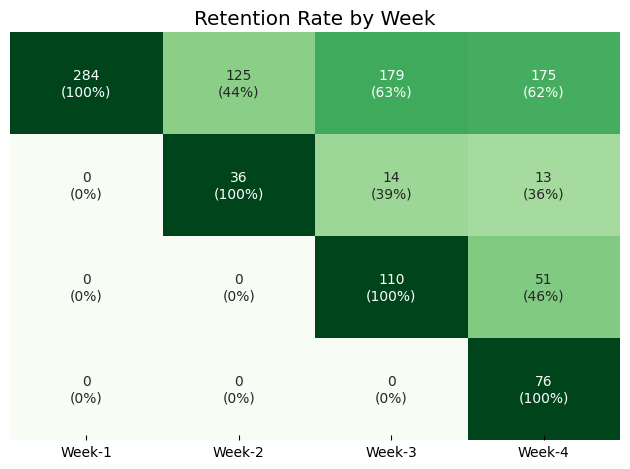

In [23]:
fig,ax = plt.subplots()
mask = np.zeros_like(cohort_pct)
mask[np.triu_indices_from(mask)] = False
# combining text with values 
formatted_text = (np.asarray(["{0}\n({1:.0f}%)".format( 
    text, data) for text, data in zip(cohort_val.astype(int).flatten(), (cohort_pct*100).flatten())])).reshape(4, 4)
sns.heatmap(cohort_pct,mask=mask,cmap='Greens',annot=formatted_text, fmt="",cbar=False)
ax.set_xticklabels(['Week-1','Week-2','Week-3','Week-4'])
# ax.set_yticklabels(['Week-1','Week-2','Week-3'])
ax.set_yticks([])
ax.set_title("Retention Rate by Week")
ax.grid(False)
plt.tight_layout()
fig.savefig('test.svg',dpi=1000)

In [24]:
start_date_base = (datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=week_base)).date()
start_date_base

datetime.date(2024, 4, 22)

#### Completion rate histogram


In [25]:
query_quiz_completion = """
with tab_mg as (
select cluster, mitra_group_id, quiz_id, quiz_start_date, quiz_end_date
from mp_ref.mp_ref_gamification_mitra_group_quiz_mapping mg
where date(mg.pareto_snapshot_dt) = "{pareto_date}" and date(mg.quiz_end_date) <= "{quiz_end_date}"
group by 1,2,3,4,5
order by 1,2,4,3),

tab_full_mitra_quiz as (
select  mgd.cluster, mgd.mitra_group_id, mgd.mitra_id, tab_mg.quiz_id, tab_mg.quiz_start_date , tab_mg.quiz_end_date
from mp_ref.mp_ref_gamification_mitra_group_details  mgd
left join tab_mg on tab_mg.mitra_group_id = mgd.mitra_group_id and tab_mg.cluster = mgd.cluster
where date(mgd.pareto_snapshot_dt) = "{pareto_date}" 
group by 1,2,3,4,5,6
order by 1,2,3,5,4), 

tab_quiz_submitted as (
select 
res.cluster,
res.mitra_group_id,
res.mitra_id, 
res.quiz_id,
min(res.submited_at) submitted_at
from mp_mst.mp_mst_gamification_result_details res
left join mp_mst.mp_mst_master_products mmmp on mmmp.prd_id = res.prd_id
where res.submited_at is not null and date(res.submited_at) <= "{submit_end_date}"
group by 1,2,3,4
order by 1,2,3,5
)


select f.cluster, 
f.mitra_group_id, 
f.mitra_id ,
f.quiz_id ,
f.quiz_start_date ,
f.quiz_end_date,
t.submitted_at
from tab_full_mitra_quiz f
left join tab_quiz_submitted t on t.mitra_group_id = f.mitra_group_id and t.mitra_id = f.mitra_id and t.quiz_id = f.quiz_id 
order by 1,2,3,5,4
"""

completion_per_mitra_df_full = myGBQ.gbq_read(query_quiz_completion.format(pareto_date = PARETO_DATE, quiz_end_date = END_DATE_QUIZ, submit_end_date = END_DATE_SUBMIT))
completion_per_mitra_df = completion_per_mitra_df_full[~pd.isna(completion_per_mitra_df_full.submitted_at)].copy()

In [27]:
num_quiz_df = completion_per_mitra_df.groupby('mitra_id',as_index=False).agg(NumQuizSolved = ('quiz_id','nunique'))
num_quiz_df['pareto_snapshot_dt'] = "2024-04-01"
num_quiz_df.to_csv(os.path.join(os.getcwd(),'datasets','QuizSolved_04.csv'),index=False)

In [26]:
completion_per_mitra_df

,cluster,mitra_group_id,mitra_id,quiz_id,quiz_start_date,quiz_end_date,submitted_at
3940,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,2024-04-15,2024-04-22,2024-04-18 11:00:40
3941,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_02,2024-04-15,2024-04-22,2024-04-18 11:00:44
3942,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_03,2024-04-15,2024-04-22,2024-04-18 11:00:49
3943,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_04,2024-04-15,2024-04-22,2024-04-18 11:00:55
3944,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_05,2024-04-16,2024-04-22,2024-04-18 11:01:15
...,...,...,...,...,...,...,...
790817,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,31723,PRIANGAN TIMUR 2_20240401_17_20,2024-04-05,2024-04-08,2024-04-05 10:53:59
791540,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_01,2024-04-22,2024-04-29,2024-04-22 15:24:59
791541,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_02,2024-04-22,2024-04-29,2024-04-22 15:25:01
791542,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_03,2024-04-22,2024-04-29,2024-04-22 15:25:08


Apr 01 - Apr 08
>80 : (94, 284, 0.33098591549295775)
>90 : (57, 284, 0.2007042253521127)
>100 : (56, 284, 0.19718309859154928)
Apr 08 - Apr 15
>80 : (108, 161, 0.6708074534161491)
>90 : (74, 161, 0.45962732919254656)
>100 : (74, 161, 0.45962732919254656)
Apr 15 - Apr 22
>80 : (131, 303, 0.43234323432343236)
>90 : (85, 303, 0.28052805280528054)
>100 : (83, 303, 0.2739273927392739)
Apr 22 - Apr 29
>80 : (157, 315, 0.4984126984126984)
>90 : (107, 315, 0.3396825396825397)
>100 : (107, 315, 0.3396825396825397)
Apr 01 - Apr 29
>80 : (74, 506, 0.14624505928853754)
>90 : (50, 506, 0.09881422924901186)
>100 : (22, 506, 0.043478260869565216)


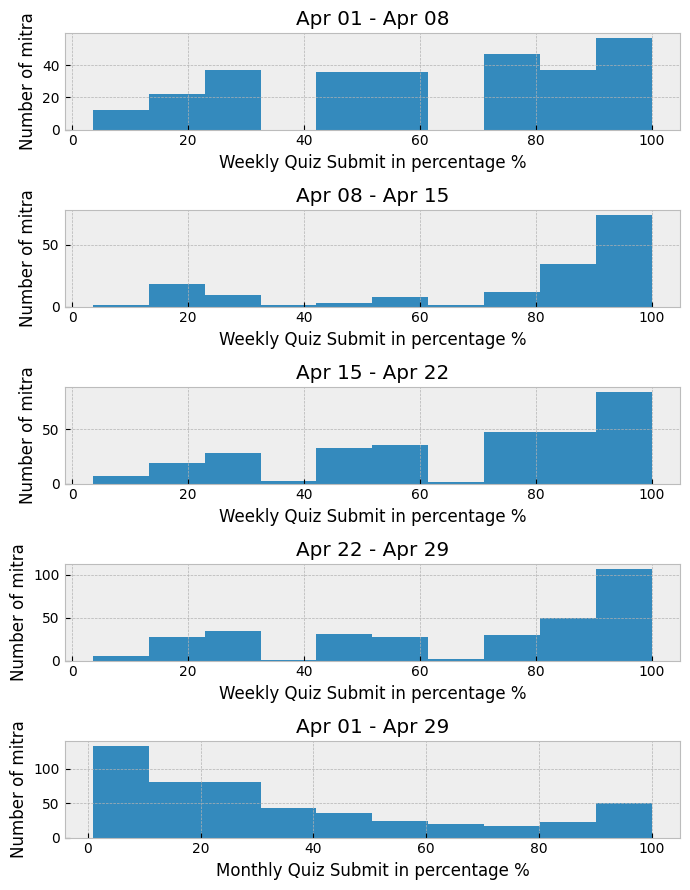

In [17]:
fig, ax = plt.subplots(5,1,figsize = (7,9))

for i in range(5) : 
    if i ==  4 :
        start_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=0)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i)
        end_date = end_date.strftime('%Y-%m-%d')
        quiz_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].groupby('mitra_id',as_index=False).agg(TotalQuizSubmitted = ('quiz_id','nunique'))
        quiz_total_df = completion_per_mitra_df_full[(completion_per_mitra_df_full.quiz_start_date >= start_date) & (completion_per_mitra_df_full.quiz_end_date <= end_date)].groupby('mitra_id',as_index=False).agg(TotalQuiz = ('quiz_id','nunique'))
        quiz_submit_df = quiz_submit_df.merge(quiz_total_df,how='left',on='mitra_id')
        quiz_submit_df['pct_submitted'] = quiz_submit_df['TotalQuizSubmitted']*100/quiz_submit_df['TotalQuiz']
        quiz_submit_df['pct_submitted'].plot.hist(ax=ax[i])
        ax[i].set_title(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}")
        ax[i].set_xlabel("Monthly Quiz Submit in percentage %")
        ax[i].set_ylabel(f"Number of mitra")
    else :
        start_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i+1)
        end_date = end_date.strftime('%Y-%m-%d')
        quiz_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].groupby('mitra_id',as_index=False).agg(TotalQuizSubmitted = ('quiz_id','nunique'))
        quiz_total_df = completion_per_mitra_df_full[(completion_per_mitra_df_full.quiz_start_date >= start_date) & (completion_per_mitra_df_full.quiz_end_date <= end_date)].groupby('mitra_id',as_index=False).agg(TotalQuiz = ('quiz_id','nunique'))
        quiz_submit_df = quiz_submit_df.merge(quiz_total_df,how='left',on='mitra_id')
        quiz_submit_df['pct_submitted'] = quiz_submit_df['TotalQuizSubmitted']*100/quiz_submit_df['TotalQuiz']
        quiz_submit_df['pct_submitted'].plot.hist(ax=ax[i])
        ax[i].set_title(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}")
        ax[i].set_xlabel("Weekly Quiz Submit in percentage %")
        ax[i].set_ylabel(f"Number of mitra")
    print(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}")
    for i in (80,90,100) : 
        
        print(f">{i} : {(quiz_submit_df[quiz_submit_df.pct_submitted >= i].shape[0],quiz_submit_df.shape[0],quiz_submit_df[quiz_submit_df.pct_submitted >= i].shape[0]/quiz_submit_df.shape[0])}")

plt.tight_layout()
# quiz_submit_df

Apr 01 - Apr 08
>5 : (43, 284, 0.15140845070422534)
>6 : (29, 284, 0.10211267605633803)
>7 : (12, 284, 0.04225352112676056)
Apr 08 - Apr 15
>5 : (36, 161, 0.2236024844720497)
>6 : (21, 161, 0.13043478260869565)
>7 : (9, 161, 0.055900621118012424)
Apr 15 - Apr 22
>5 : (60, 303, 0.19801980198019803)
>6 : (45, 303, 0.1485148514851485)
>7 : (25, 303, 0.08250825082508251)
Apr 22 - Apr 29
>5 : (69, 315, 0.21904761904761905)
>6 : (45, 315, 0.14285714285714285)
>7 : (29, 315, 0.09206349206349207)
Apr 01 - Apr 29
>5 : (177, 506, 0.34980237154150196)
>6 : (152, 506, 0.30039525691699603)
>7 : (134, 506, 0.2648221343873518)


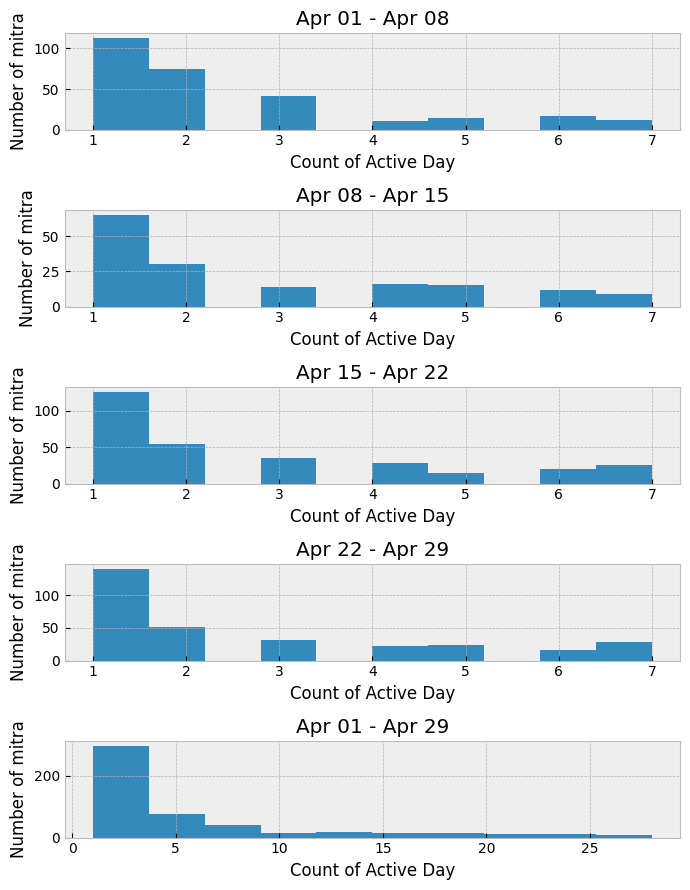

In [18]:
fig, ax = plt.subplots(5,1,figsize = (7,9))

for i in range(5) : 
    if i ==  4 :
        start_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=0)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i)
        end_date = end_date.strftime('%Y-%m-%d')
        quiz_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].groupby('mitra_id',as_index=False).agg(TotalQuizSubmitted = ('quiz_id','nunique'))
        quiz_total_df = completion_per_mitra_df_full[(completion_per_mitra_df_full.quiz_start_date >= start_date) & (completion_per_mitra_df_full.quiz_end_date <= end_date)].groupby('mitra_id',as_index=False).agg(TotalQuiz = ('quiz_id','nunique'))
        quiz_submit_df = quiz_submit_df.merge(quiz_total_df,how='left',on='mitra_id')
        quiz_submit_df['pct_submitted'] = quiz_submit_df['TotalQuizSubmitted']*100/quiz_submit_df['TotalQuiz']
        day_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].assign(date_submitted_at = lambda x:x['submitted_at'].dt.strftime("%Y-%m-%d")).groupby('mitra_id',as_index=False).date_submitted_at.nunique()
        quiz_submit_df = quiz_submit_df.merge(day_submit_df,how='left',on='mitra_id')
        quiz_submit_df['date_submitted_at'].plot.hist(ax=ax[i])
        ax[i].set_title(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}")
        ax[i].set_xlabel("Count of Active Day")
        ax[i].set_ylabel(f"Number of mitra")
    else :
        start_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i+1)
        end_date = end_date.strftime('%Y-%m-%d')
        quiz_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].groupby('mitra_id',as_index=False).agg(TotalQuizSubmitted = ('quiz_id','nunique'))
        quiz_total_df = completion_per_mitra_df_full[(completion_per_mitra_df_full.quiz_start_date >= start_date) & (completion_per_mitra_df_full.quiz_end_date <= end_date)].groupby('mitra_id',as_index=False).agg(TotalQuiz = ('quiz_id','nunique'))
        quiz_submit_df = quiz_submit_df.merge(quiz_total_df,how='left',on='mitra_id')
        quiz_submit_df['pct_submitted'] = quiz_submit_df['TotalQuizSubmitted']*100/quiz_submit_df['TotalQuiz']
        day_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].assign(date_submitted_at = lambda x:x['submitted_at'].dt.strftime("%Y-%m-%d")).groupby('mitra_id',as_index=False).date_submitted_at.nunique()
        quiz_submit_df = quiz_submit_df.merge(day_submit_df,how='left',on='mitra_id')
        quiz_submit_df['date_submitted_at'].plot.hist(ax=ax[i])
        ax[i].set_title(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}")
        ax[i].set_xlabel("Count of Active Day")
        ax[i].set_ylabel(f"Number of mitra")
    print(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}")
    for i in (5,6,7) : 
        
        print(f">{i} : {(quiz_submit_df[quiz_submit_df.date_submitted_at >= i].shape[0],quiz_submit_df.shape[0],quiz_submit_df[quiz_submit_df.date_submitted_at >= i].shape[0]/quiz_submit_df.shape[0])}")

plt.tight_layout()
# quiz_submit_df

In [19]:
completion_per_mitra_df_full['quiz_start_date_dow'] = completion_per_mitra_df_full['quiz_start_date'].apply(lambda x:x.weekday())
completion_per_mitra_df_full['submitted_at_dow'] = completion_per_mitra_df_full['submitted_at'].apply(lambda x:x.weekday())
completion_per_mitra_df_full['submitted_at'] = completion_per_mitra_df_full['submitted_at'].dt.date
number_quiz_each_day = completion_per_mitra_df_full.groupby(['cluster','mitra_group_id','mitra_id','quiz_start_date','quiz_start_date_dow'],as_index=False).quiz_id.nunique()
number_quiz_each_day.columns = ['cluster','mitra_group_id','mitra_id','date','dow','num_quiz_day']
number_quiz_each_day['date'] = number_quiz_each_day['date'].astype(str)
number_quiz_solved_day = completion_per_mitra_df_full[~pd.isna(completion_per_mitra_df_full.submitted_at)].groupby(['cluster','mitra_group_id','mitra_id','submitted_at','submitted_at_dow'],as_index=False).quiz_id.nunique()
number_quiz_solved_day.columns = ['cluster','mitra_group_id','mitra_id','date','dow','num_quiz_solved']
number_quiz_solved_day['date'] = number_quiz_solved_day['date'].astype(str)
number_quiz_each_day = number_quiz_each_day.merge(number_quiz_solved_day,how='left',left_on=['cluster','mitra_group_id','mitra_id','date','dow'],right_on=['cluster','mitra_group_id','mitra_id','date','dow'])
number_quiz_each_day['num_quiz_solved'] = number_quiz_each_day['num_quiz_solved'].fillna(0) 
number_quiz_each_day['completion_rate'] = number_quiz_each_day['num_quiz_solved']*100/number_quiz_each_day['num_quiz_day']

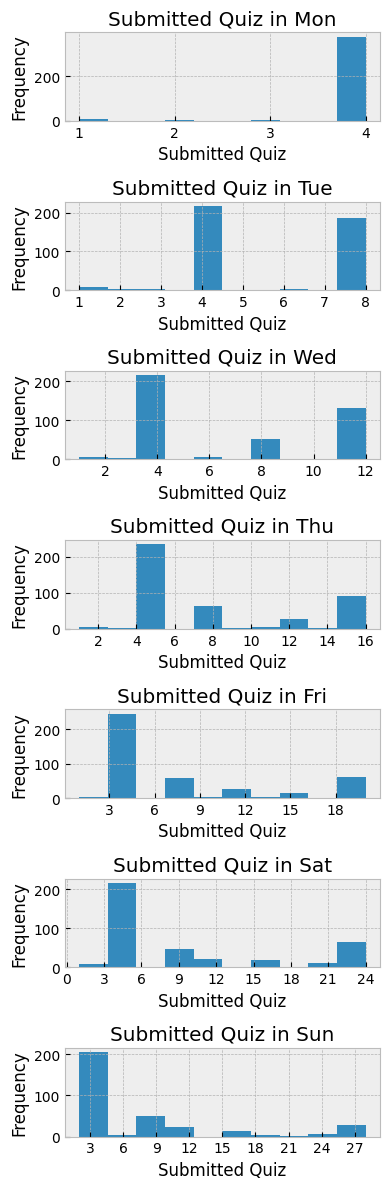

In [20]:
fig,ax=plt.subplots(7,1,figsize=(4,12))
for idx,days_ in enumerate(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']) :
    number_quiz_each_day[(number_quiz_each_day.dow==idx) & (number_quiz_each_day.num_quiz_solved>0)].num_quiz_solved.plot.hist(ax=ax[idx])
    ax[idx].set_title(f'Submitted Quiz in {days_}')
    ax[idx].set_xlabel(f'Submitted Quiz')
    ax[idx].set_ylabel('Frequency')
    ax[idx].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    if idx==6:
        pass
        # ax[idx].set_xticks([0,100,200,300,400,500,600,700,800,900])
plt.tight_layout()
                       
               

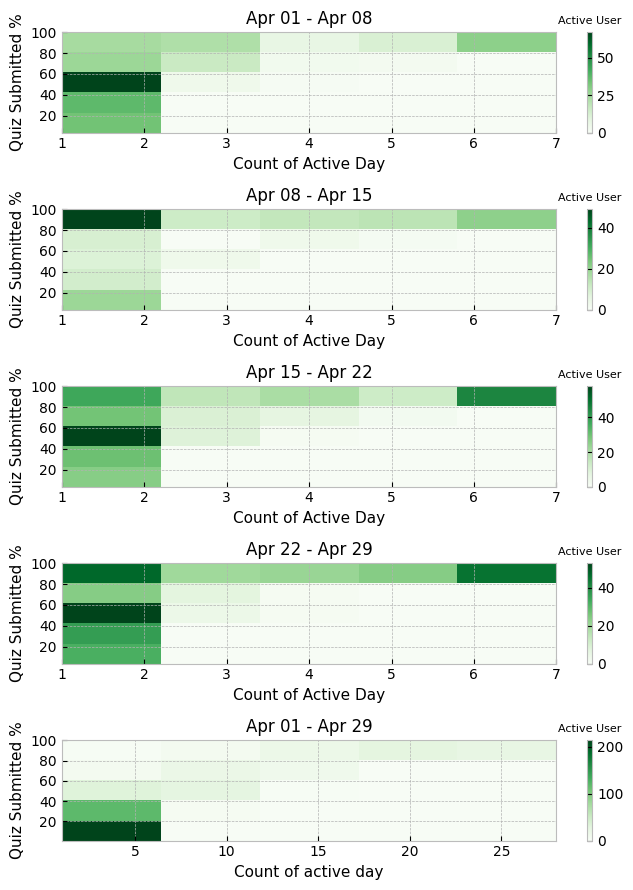

In [21]:
fig, ax = plt.subplots(5,1,figsize = (7,9))

for i in range(5) : 
    if i ==  4 :
        start_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=0)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i)
        end_date = end_date.strftime('%Y-%m-%d')
        quiz_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].groupby('mitra_id',as_index=False).agg(TotalQuizSubmitted = ('quiz_id','nunique'))
        quiz_total_df = completion_per_mitra_df_full[(completion_per_mitra_df_full.quiz_start_date >= start_date) & (completion_per_mitra_df_full.quiz_end_date <= end_date)].groupby('mitra_id',as_index=False).agg(TotalQuiz = ('quiz_id','nunique'))
        quiz_submit_df = quiz_submit_df.merge(quiz_total_df,how='left',on='mitra_id')
        quiz_submit_df['pct_submitted'] = quiz_submit_df['TotalQuizSubmitted']*100/quiz_submit_df['TotalQuiz']
        day_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].assign(date_submitted_at = lambda x:x['submitted_at'].dt.strftime("%Y-%m-%d")).groupby('mitra_id',as_index=False).date_submitted_at.nunique()
        quiz_submit_df = quiz_submit_df.merge(day_submit_df,how='left',on='mitra_id')
        counts, xedges, yedges, im= ax[i].hist2d(x=quiz_submit_df.date_submitted_at,y=quiz_submit_df.pct_submitted,density = False,bins=5,cmap='Greens')
        cb = fig.colorbar(im,ax=ax[i])
        cb.ax.set_title('Active User',fontsize=8)
        ax[i].set_title(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}",fontsize=12)
        ax[i].set_xlabel("Count of active day",fontsize=11)
        ax[i].set_ylabel(f"Quiz Submitted %",fontsize=11)
    
    else :
        start_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i)
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = datetime.strptime(START_DATE,'%Y-%m-%d') + relativedelta(weeks=i+1)
        end_date = end_date.strftime('%Y-%m-%d')
        quiz_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].groupby('mitra_id',as_index=False).agg(TotalQuizSubmitted = ('quiz_id','nunique'))
        quiz_total_df = completion_per_mitra_df_full[(completion_per_mitra_df_full.quiz_start_date >= start_date) & (completion_per_mitra_df_full.quiz_end_date <= end_date)].groupby('mitra_id',as_index=False).agg(TotalQuiz = ('quiz_id','nunique'))
        quiz_submit_df = quiz_submit_df.merge(quiz_total_df,how='left',on='mitra_id')
        quiz_submit_df['pct_submitted'] = quiz_submit_df['TotalQuizSubmitted']*100/quiz_submit_df['TotalQuiz']
        day_submit_df = completion_per_mitra_df[(completion_per_mitra_df.submitted_at >= start_date) & (completion_per_mitra_df.submitted_at < end_date)].assign(date_submitted_at = lambda x:x['submitted_at'].dt.strftime("%Y-%m-%d")).groupby('mitra_id',as_index=False).date_submitted_at.nunique()
        quiz_submit_df = quiz_submit_df.merge(day_submit_df,how='left',on='mitra_id')
        counts, xedges, yedges, im= ax[i].hist2d(x=quiz_submit_df.date_submitted_at,y=quiz_submit_df.pct_submitted,density = False,bins=5,cmap='Greens')
        cb = fig.colorbar(im,ax=ax[i])
        cb.ax.set_title('Active User',fontsize=8)
        ax[i].set_title(f"{datetime.strptime(start_date,'%Y-%m-%d').strftime('%b %d')} - {datetime.strptime(end_date,'%Y-%m-%d').strftime('%b %d')}",fontsize=12)
        ax[i].set_xlabel("Count of Active Day",fontsize=11)
        ax[i].set_ylabel(f"Quiz Submitted %",fontsize=11)
    ax[i].set_yticks([20,40,60,80,100])
    ax[i].set_yticklabels([20,40,60,80,100])


plt.tight_layout()
# quiz_submit_df

In [22]:
query_gami_pareto_prd = f"""
select prd_l.cluster,prd_l.prd_id, prd_l.is_assortment 
from mp_ref.mp_ref_gamification_prd_list prd_l
where prd_l.pareto_snapshot_dt = "2024-04-01"
group by 1,2,3
"""

assort_flag = myGBQ.gbq_read(query_gami_pareto_prd)

Text(0, 0.5, 'Frequency')

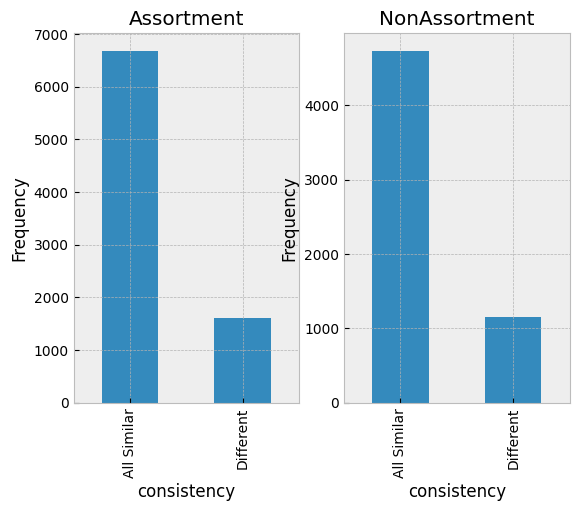

In [23]:
df_raw['result_idx'] = df_raw.result.apply(lambda x: 1 if x is True else 0)
aggregate_prd_mitra_enc = df_raw.groupby(['cluster','mitra_id','prd_id'],as_index=False).agg(Encounter = ('quiz_mitra_id','nunique'), true_count = ('result_idx','sum'))
aggregate_prd_mitra_enc = aggregate_prd_mitra_enc[aggregate_prd_mitra_enc.Encounter == 3]
aggregate_prd_mitra_enc['consistency'] = aggregate_prd_mitra_enc.true_count.apply(lambda x: max(3-x,x)/3)
aggregate_prd_mitra_enc['consistency'] = aggregate_prd_mitra_enc.consistency.apply(lambda x: 'All Similar' if x == 1 else "Different")
aggregate_prd_mitra_enc = aggregate_prd_mitra_enc.merge(assort_flag,how='left',on=['cluster','prd_id'])
aggregate_prd_mitra_enc['mitra_prd_idx'] = aggregate_prd_mitra_enc['mitra_id'].astype(str) + "_" + aggregate_prd_mitra_enc['prd_id'].astype(str)
fig , ax = plt.subplots(1,2)
aggregate_prd_mitra_enc[aggregate_prd_mitra_enc.is_assortment == True].groupby('consistency').mitra_prd_idx.nunique().plot.bar(ax=ax[0])
ax[0].set_title('Assortment')
ax[0].set_ylabel('Frequency')
aggregate_prd_mitra_enc[aggregate_prd_mitra_enc.is_assortment == False].groupby('consistency').mitra_prd_idx.nunique().plot.bar(ax=ax[1])
ax[1].set_title('NonAssortment')
ax[1].set_ylabel('Frequency')

In [24]:
aggregate_prd_mitra_enc[aggregate_prd_mitra_enc.is_assortment == False].consistency.value_counts()

consistency
All Similar    4735
Different      1149
Name: count, dtype: int64

In [25]:
aggregate_prd_mitra_enc

,cluster,mitra_id,prd_id,Encounter,true_count,consistency,is_assortment,mitra_prd_idx
0,BANDUNG RAYA,6938,28,3,2,Different,True,6938_28
1,BANDUNG RAYA,6938,162,3,3,All Similar,True,6938_162
2,BANDUNG RAYA,6938,190,3,3,All Similar,False,6938_190
3,BANDUNG RAYA,6938,272,3,0,All Similar,True,6938_272
4,BANDUNG RAYA,6938,602,3,0,All Similar,False,6938_602
...,...,...,...,...,...,...,...,...
14666,PRIANGAN TIMUR 2,55414,14287,3,2,Different,False,55414_14287
14667,PRIANGAN TIMUR 2,55414,23460,3,1,Different,False,55414_23460
14668,PRIANGAN TIMUR 2,55414,25894,3,3,All Similar,True,55414_25894
14669,PRIANGAN TIMUR 2,55414,26129,3,1,Different,True,55414_26129


#### How many assortment products in the top 50

In [26]:
query_prd_bundling = """
select p360.prd_id , 
p360.is_bndl
from mp_mst.mp_mst_master_products_360 p360
where p360.deleted_at is null and p360.is_active is True
group by 1,2

"""
df_prd_bundle = myGBQ.gbq_read(query_prd_bundling)

In [27]:
## See how many each products were choosen with quiz_id-mitra basis
choosen_num_quiz = df_raw[df_raw.result == True].groupby(['cluster','prd_id'],as_index=False).agg(total_choosen_quiz = ('quiz_mitra_id' , 'nunique'),
                                                                                                 total_choosen_mitra = ('mitra_id','nunique'))

## See how many each products were seen
seen_num_quiz =  df_raw.groupby(['cluster','prd_id'],as_index=False).agg(total_seen_quiz = ('quiz_mitra_id' , 'nunique'),
                                                                                                 total_seen_mitra = ('mitra_id','nunique'))

## Nonduplicate assortment flag per cluster
assortment_flag_cluster = df_raw[['cluster','prd_id','assortment_flag']].drop_duplicates(subset=['cluster','prd_id','assortment_flag'],keep='first',inplace=False)

## Join them all 
result_quiz_basis = seen_num_quiz.merge(choosen_num_quiz, how='left', on = ['cluster','prd_id'])
result_quiz_basis = result_quiz_basis.merge(assortment_flag_cluster,how='left',on = ['cluster','prd_id'])
result_quiz_basis = result_quiz_basis.merge(df_raw[['prd_name','prd_id']].drop_duplicates(keep='first'),how='left',on = 'prd_id')
result_quiz_basis = result_quiz_basis.merge(df_prd_bundle,how='left',on='prd_id')

result_quiz_basis['is_bndl'] = result_quiz_basis['is_bndl'].fillna(False) 

## Fillna 
result_quiz_basis['total_choosen_quiz'] = result_quiz_basis['total_choosen_quiz'].fillna(0).astype(int)
result_quiz_basis['total_choosen_mitra'] = result_quiz_basis['total_choosen_mitra'].fillna(0).astype(int)

# Create choosen rate 
result_quiz_basis['choosen_quiz_rate'] = result_quiz_basis['total_choosen_quiz']/result_quiz_basis['total_seen_quiz']
result_quiz_basis['choosen_mitra_rate'] = result_quiz_basis['total_choosen_mitra']/result_quiz_basis['total_seen_mitra']

## Ranking based on quiz seen

MINIMAL_MITRA_SUBMITTED = 3
filtered_rank_df = result_quiz_basis[result_quiz_basis.total_seen_mitra >= MINIMAL_MITRA_SUBMITTED].copy()
filtered_rank_df['prd_label'] = filtered_rank_df[['is_bndl','assortment_flag']].apply(lambda x:'assortment' if x['assortment_flag'] else 'bundle' if x['is_bndl'] else 'non-assortment',axis=1)

print(f"With minimal mitra  seen as {MINIMAL_MITRA_SUBMITTED} , the number of observable prd in each cluster : {filtered_rank_df.groupby('cluster').prd_id.nunique()}")
filtered_rank_df_quiz = filtered_rank_df.sort_values(['choosen_quiz_rate','total_choosen_quiz','choosen_mitra_rate','total_choosen_mitra'],ascending=[False,False,False,False]).copy()
filtered_rank_df_mitra = filtered_rank_df.sort_values(['choosen_mitra_rate','total_seen_mitra'],ascending=[False,False]).copy()
filtered_rank_df_quiz['rank'] = filtered_rank_df_quiz.groupby('cluster',sort=False)['cluster'].rank(method='first',ascending=False)
filtered_rank_df_mitra['rank'] = filtered_rank_df_mitra.groupby('cluster',sort=False)['cluster'].rank(method='first',ascending=False)
filtered_rank_df_quiz=filtered_rank_df_quiz.sort_values(['cluster','rank'])
filtered_rank_df_mitra = filtered_rank_df_mitra.sort_values(['cluster','rank'])




                                                                                                                                                                                                    

With minimal mitra  seen as 3 , the number of observable prd in each cluster : cluster
BANDUNG RAYA        676
BOCIMI              611
CIAYUMAJAKUNING     616
KAPURSUB            604
PRIANGAN TIMUR 1    684
PRIANGAN TIMUR 2    365
Name: prd_id, dtype: int64


In [28]:
filtered_rank_df_quiz

,cluster,prd_id,total_seen_quiz,total_seen_mitra,total_choosen_quiz,total_choosen_mitra,assortment_flag,prd_name,is_bndl,choosen_quiz_rate,choosen_mitra_rate,prd_label,rank
159,BANDUNG RAYA,1022,16,7,16,7,True,Demolish 18EC 100ml,False,1.0,1.0,assortment,1.0
195,BANDUNG RAYA,1375,12,5,12,5,True,Gramoxone 276SL 500ml,False,1.0,1.0,assortment,2.0
382,BANDUNG RAYA,4322,9,4,9,4,True,NPK Mutiara 16-16-16 1Kg,False,1.0,1.0,assortment,3.0
194,BANDUNG RAYA,1374,7,5,7,5,True,Gramoxone 276SL 250ml,False,1.0,1.0,assortment,4.0
70,BANDUNG RAYA,239,6,4,6,4,True,Emacel 30EC 250ml,False,1.0,1.0,assortment,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,PRIANGAN TIMUR 2,25890,15,7,0,0,True,Draxone 150SL 4L,False,0.0,0.0,assortment,361.0
3927,PRIANGAN TIMUR 2,25898,9,4,0,0,True,Metilon 20WP 50ml,False,0.0,0.0,assortment,362.0
3930,PRIANGAN TIMUR 2,25901,9,3,0,0,True,Metrozine 50WG 100gr,False,0.0,0.0,assortment,363.0
3936,PRIANGAN TIMUR 2,26016,16,6,0,0,True,Indoxamyl 3G 1L,False,0.0,0.0,assortment,364.0


for cluster : BANDUNG RAYA
assortment        52
bundle             0
non-assortment     8
dtype: int64
for cluster : BOCIMI
assortment        53
bundle             1
non-assortment     6
dtype: int64
for cluster : CIAYUMAJAKUNING
assortment        46
bundle             0
non-assortment    14
dtype: int64
for cluster : KAPURSUB
assortment        52
bundle             1
non-assortment     7
dtype: int64
for cluster : PRIANGAN TIMUR 1
assortment        50
bundle             1
non-assortment     9
dtype: int64
for cluster : PRIANGAN TIMUR 2
assortment        38
bundle             5
non-assortment    17
dtype: int64


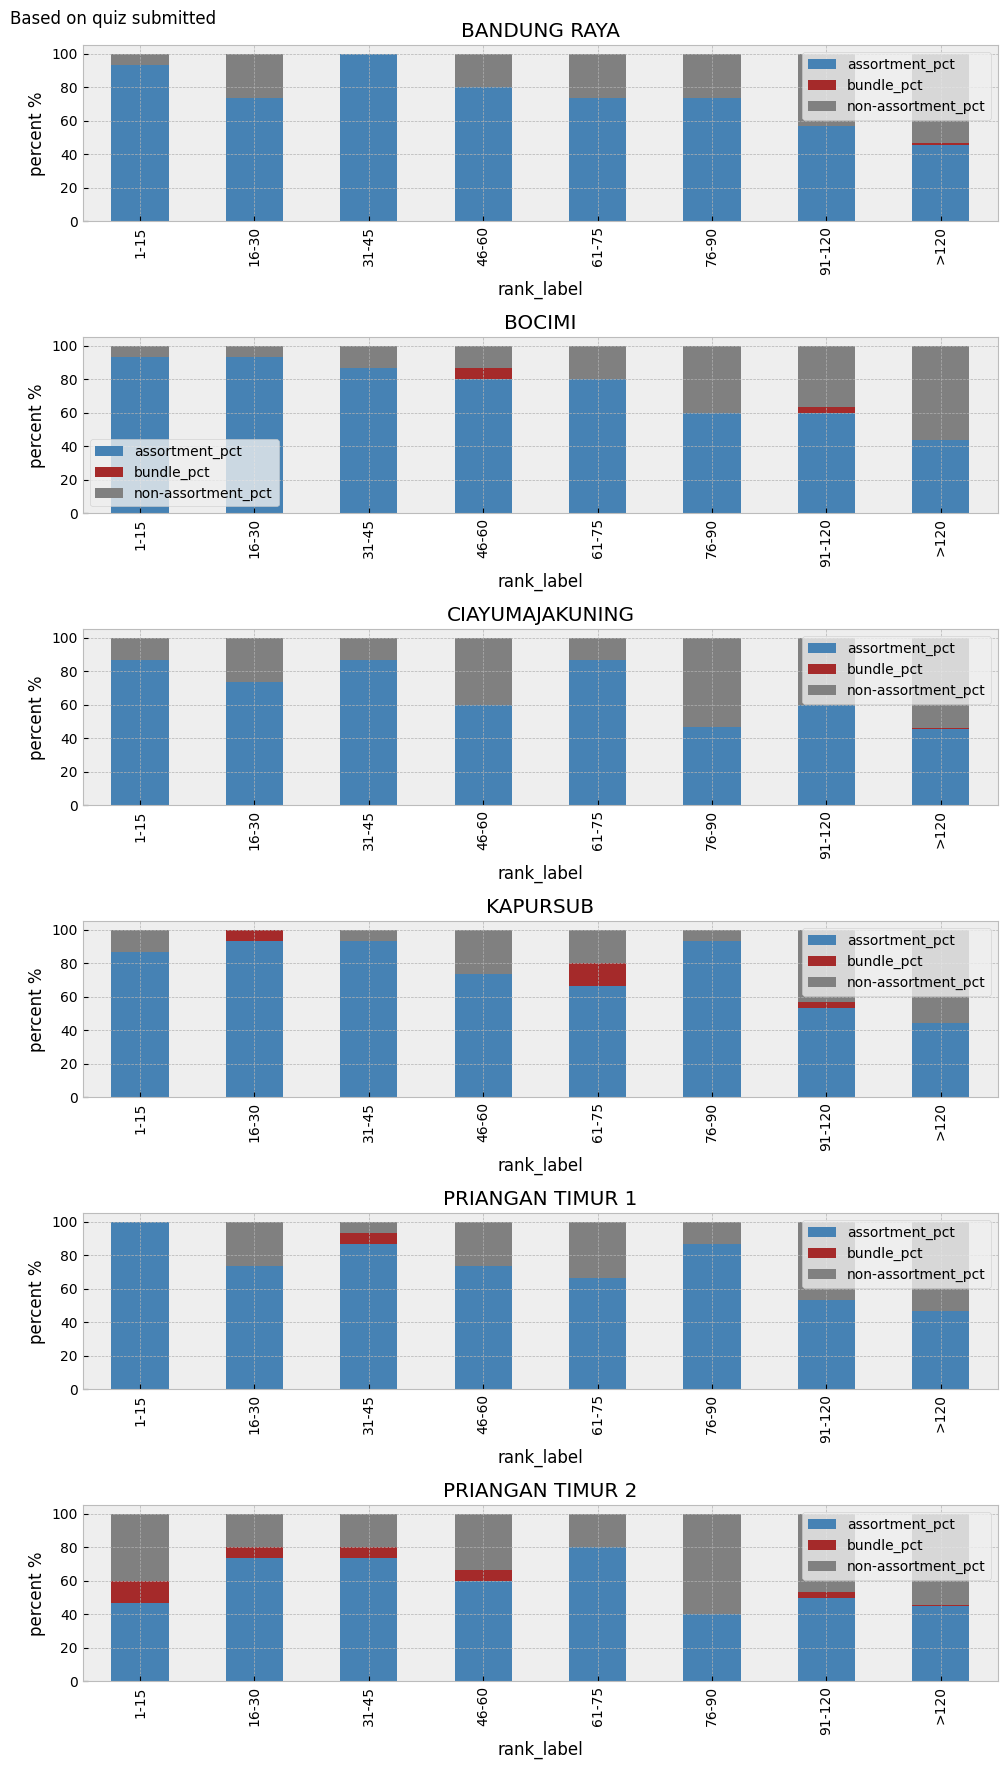

In [37]:
calculated_df = filtered_rank_df_quiz.copy()
# calculated_df = calculated_df[calculated_df['prd_label']!='bundle']
# calculated_df['cluster']= calculated_df['cluster'].apply(lambda x : 'PRIANGAN TIMUR' if x in ['PRIANGAN TIMUR 1','PRIANGAN TIMUR 2'] else x )
res = []
for idx,cluster_ in enumerate(calculated_df.cluster.unique()) :
    rank_arr = calculated_df[calculated_df.cluster==cluster_]['rank'].to_numpy()
    rank_idx_string = ['1-15','16-30','31-45','46-60','61-75','76-90','91-120','>120']
    rank_idx_splitter = [15,30,45,60,75,90,120,10000]
    rank_splitted = np.split(rank_arr,rank_idx_splitter)
    pop_last_element =  rank_splitted.pop()
    for splitted_idx,splitted_arr in zip(rank_idx_string, rank_splitted) :
        total_prd =  calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        total_prd_assortment = calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['prd_label']=='assortment') & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        total_prd_bundle = calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['prd_label']=='bundle') & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        total_prd_nonassortment = calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['prd_label']=='non-assortment') & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        res.append((cluster_,splitted_idx,total_prd_assortment,total_prd_bundle,total_prd_nonassortment,total_prd_assortment*100/total_prd,total_prd_bundle*100/total_prd,total_prd_nonassortment*100/total_prd))

res_bin_df = pd.DataFrame.from_records(res,columns=['cluster','rank_label','assortment','bundle','non-assortment','assortment_pct','bundle_pct','non-assortment_pct'])
fig,ax = plt.subplots(res_bin_df.cluster.nunique(),1,figsize=(10,18))

for idx,cluster_ in enumerate(calculated_df.cluster.unique()) : 
    res_bin_df[res_bin_df.cluster==cluster_].set_index('rank_label')[['assortment_pct','bundle_pct','non-assortment_pct']].plot.bar(stacked=True,ax=ax[idx],color=['steelblue','brown','gray'])
    ax[idx].set_title(f'{cluster_.upper()}')
    ax[idx].set_ylabel('percent %')
    print(f"for cluster : {cluster_}")
    print(res_bin_df[(res_bin_df.cluster==cluster_) & (res_bin_df.rank_label.isin(['1-15','16-30','31-45','46-60']))][['assortment','bundle','non-assortment']].sum())
fig.suptitle('Based on quiz submitted',x=0.1)
plt.tight_layout()
    

In [36]:
filtered_rank_df

,cluster,prd_id,total_seen_quiz,total_seen_mitra,total_choosen_quiz,total_choosen_mitra,assortment_flag,prd_name,is_bndl,choosen_quiz_rate,choosen_mitra_rate,prd_label
0,BANDUNG RAYA,1,5,4,3,3,True,Abenz 22EC 100ml,False,0.600000,0.750,assortment
1,BANDUNG RAYA,2,15,5,8,4,True,Abenz 22EC 250ml,False,0.533333,0.800,assortment
2,BANDUNG RAYA,4,15,8,1,1,False,Agil 100EC 100ml,False,0.066667,0.125,non-assortment
3,BANDUNG RAYA,6,8,4,2,2,True,Acrobat 50WP 40gr,False,0.250000,0.500,assortment
4,BANDUNG RAYA,9,26,12,5,3,False,Agus 500SC 250ml,False,0.192308,0.250,non-assortment
...,...,...,...,...,...,...,...,...,...,...,...,...
3943,PRIANGAN TIMUR 2,26290,9,3,5,3,False,25 Broad Plus 77WP 40gr + 25 Roundup Biosorb 4...,True,0.555556,1.000,bundle
3944,PRIANGAN TIMUR 2,26291,12,5,9,5,False,5 Furadan 3GR 2Kg + 10 Gramoxone 276SL 500ml,True,0.750000,1.000,bundle
3945,PRIANGAN TIMUR 2,26292,12,5,11,5,False,5 Furadan 3GR 2Kg + 12 NPK Mutiara 16-16-16 1Kg,True,0.916667,1.000,bundle
3946,PRIANGAN TIMUR 2,26293,5,3,4,3,False,5 Furadan 3GR 2Kg + 25 Roundup Biosorb 486SL 2...,True,0.800000,1.000,bundle


In [32]:
res_bin_df

,cluster,rank_label,assortment,bundle,non-assortment,assortment_pct,bundle_pct,non-assortment_pct
0,BANDUNG RAYA,1-15,14,0,1,93.333333,0.000000,6.666667
1,BANDUNG RAYA,16-30,11,0,4,73.333333,0.000000,26.666667
2,BANDUNG RAYA,31-45,15,0,0,100.000000,0.000000,0.000000
3,BANDUNG RAYA,46-60,12,0,3,80.000000,0.000000,20.000000
4,BANDUNG RAYA,61-75,11,0,4,73.333333,0.000000,26.666667
5,BANDUNG RAYA,76-90,11,0,4,73.333333,0.000000,26.666667
6,BANDUNG RAYA,91-120,17,0,13,56.666667,0.000000,43.333333
7,BANDUNG RAYA,>120,254,5,297,45.683453,0.899281,53.417266
8,BOCIMI,1-15,14,0,1,93.333333,0.000000,6.666667
9,BOCIMI,16-30,14,0,1,93.333333,0.000000,6.666667


In [36]:
final_rank_df = filtered_rank_df_quiz.copy()
final_rank_df.columns = ['cluster','prd_id','appearance','mitra_view','total_choosen_quiz','total_choosen_mitra','assortment_flag','prd_name','is_bndl','choosen_quiz_rate','choosen_mitra_rate','prd_label','rank']
final_rank_df[final_rank_df.cluster == "PRIANGAN TIMUR 2"].head(15)

,cluster,prd_id,appearance,mitra_view,total_choosen_quiz,total_choosen_mitra,assortment_flag,prd_name,is_bndl,choosen_quiz_rate,choosen_mitra_rate,prd_label,rank
3717,PRIANGAN TIMUR 2,4162,15,5,15,5,True,Benih Timun Semi F1 20gr,False,1.000000,1.000000,assortment,1.0
3722,PRIANGAN TIMUR 2,4316,15,5,15,5,True,Gandasil D 100gr,False,1.000000,1.000000,assortment,2.0
3633,PRIANGAN TIMUR 2,1375,10,4,10,4,True,Gramoxone 276SL 500ml,False,1.000000,1.000000,assortment,3.0
3660,PRIANGAN TIMUR 2,1961,10,4,10,4,False,Pegasus 500SC 80ml,False,1.000000,1.000000,non-assortment,4.0
3544,PRIANGAN TIMUR 2,168,7,3,7,3,True,Abacel 18EC 100ml,False,1.000000,1.000000,assortment,5.0
3621,PRIANGAN TIMUR 2,1112,7,3,7,3,False,Dumil 40SP 400gr,False,1.000000,1.000000,non-assortment,6.0
3532,PRIANGAN TIMUR 2,115,5,3,5,3,True,Roundup Biosorb 486SL 1L,False,1.000000,1.000000,assortment,7.0
3630,PRIANGAN TIMUR 2,1325,5,3,5,3,False,Gibgro Panen 20SP 1gr,False,1.000000,1.000000,non-assortment,8.0
3696,PRIANGAN TIMUR 2,3338,5,3,5,3,False,Benih Bayam Amarin Bintang Asia 500gr,False,1.000000,1.000000,non-assortment,9.0
3723,PRIANGAN TIMUR 2,4317,17,6,16,6,True,Gandasil D 500gr,False,0.941176,1.000000,assortment,10.0


In [97]:
print(paste_df_str(final_rank_df[final_rank_df.cluster == "BOCIMI"].head(15)))

cluster,prd_id,appearance,mitra_view,total_choosen_quiz,total_choosen_mitra,assortment_flag,prd_name,is_bndl,choosen_quiz_rate,choosen_mitra_rate,prd_label,rank
BOCIMI,762,24,8,24,8,True,Broad Plus 77WP 40gr,False,1.0,1.0,assortment,1.0
BOCIMI,40,14,8,14,8,True,Gramoxone 276SL 1L,False,1.0,1.0,assortment,2.0
BOCIMI,1374,12,6,12,6,True,Gramoxone 276SL 250ml,False,1.0,1.0,assortment,3.0
BOCIMI,3311,9,5,9,5,True,Benih Jagung Manis Exotic 1750 Butir,False,1.0,1.0,assortment,4.0
BOCIMI,136,23,9,22,9,True,Sidamethrin 50EC 100ml,False,0.9565217391304348,1.0,assortment,5.0
BOCIMI,4553,22,14,21,13,True,Kalsium Manohara 1Kg,False,0.9545454545454546,0.9285714285714286,assortment,6.0
BOCIMI,4317,38,14,36,14,True,Gandasil D 500gr,False,0.9473684210526315,1.0,assortment,7.0
BOCIMI,50,29,13,27,13,True,Antracol 70WP 1Kg,False,0.9310344827586207,1.0,assortment,8.0
BOCIMI,33,27,9,25,9,True,Furadan 3GR 2Kg,False,0.9259259259259259,1.0,assortment,9.0
BOCIMI,226,40,14,37,13,True,Curacron 500EC 100ml,False,

In [99]:
final_rank_df['choosen_quiz_rate'] =  final_rank_df['choosen_quiz_rate']*100
final_rank_df['choosen_mitra_rate'] =  final_rank_df['choosen_mitra_rate']*100
final_rank_df.to_csv(os.path.join(os.getcwd(),'datasets','full_result.csv'))

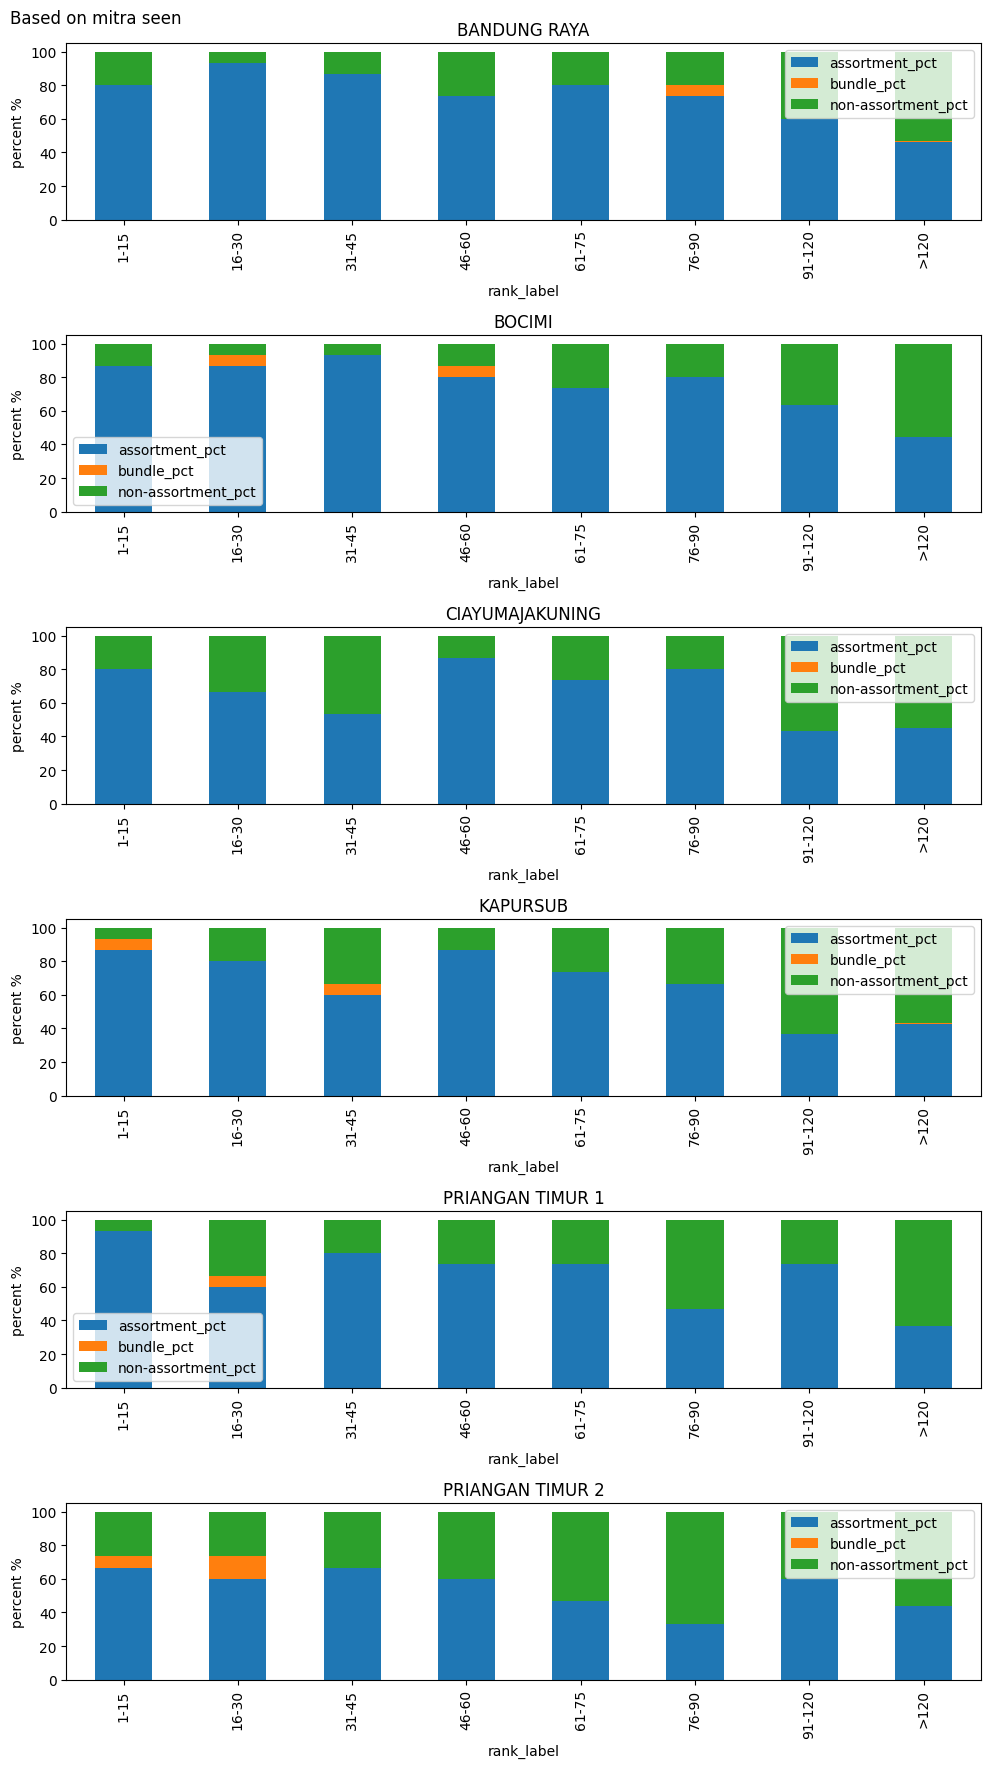

In [230]:
calculated_df = filtered_rank_df_mitra.copy()

res = []
for idx,cluster_ in enumerate(filtered_rank_df.cluster.unique()) :
    rank_arr = calculated_df[calculated_df.cluster==cluster_]['rank'].to_numpy()
    rank_idx_string = ['1-15','16-30','31-45','46-60','61-75','76-90','91-120','>120']
    rank_idx_splitter = [15,30,45,60,75,90,120,10000]
    rank_splitted = np.split(rank_arr,rank_idx_splitter)
    pop_last_element =  rank_splitted.pop()
    for splitted_idx,splitted_arr in zip(rank_idx_string, rank_splitted) :
        total_prd =  calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        total_prd_assortment = calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['prd_label']=='assortment') & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        total_prd_bundle = calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['prd_label']=='bundle') & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        total_prd_nonassortment = calculated_df[(calculated_df.cluster==cluster_) & (calculated_df['prd_label']=='non-assortment') & (calculated_df['rank'].isin(list(splitted_arr)))].prd_id.nunique()
        res.append((cluster_,splitted_idx,total_prd_assortment,total_prd_bundle,total_prd_nonassortment,total_prd_assortment*100/total_prd,total_prd_bundle*100/total_prd,total_prd_nonassortment*100/total_prd))

res_bin_df = pd.DataFrame.from_records(res,columns=['cluster','rank_label','assortment','bundle','non-assortment','assortment_pct','bundle_pct','non-assortment_pct'])
fig,ax = plt.subplots(res_bin_df.cluster.nunique(),1,figsize=(10,18))
for idx,cluster_ in enumerate(res_bin_df.cluster.unique()) : 
    res_bin_df[res_bin_df.cluster==cluster_].set_index('rank_label')[['assortment_pct','bundle_pct','non-assortment_pct']].plot.bar(stacked=True,ax=ax[idx])
    ax[idx].set_title(f'{cluster_.upper()}')
    ax[idx].set_ylabel('percent %')
fig.suptitle('Based on mitra seen',x=0.1)
plt.tight_layout()
    

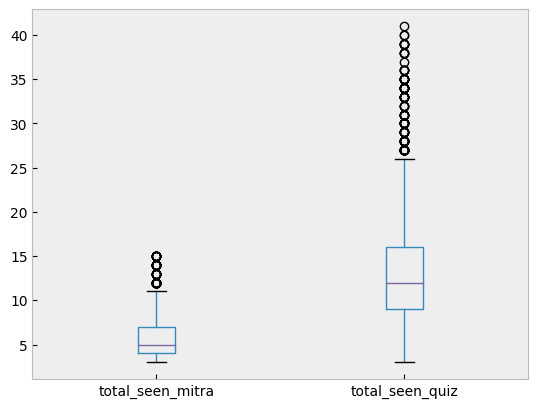

In [76]:
fig,ax = plt.subplots()
filtered_rank_df.boxplot(column=['total_seen_mitra','total_seen_quiz'],ax=ax)
ax.grid(False)


In [234]:
result_quiz_basis[result_quiz_basis.prd_name.str.contains('NPK')]

,cluster,prd_id,total_seen_quiz,total_seen_mitra,total_choosen_quiz,total_choosen_mitra,assortment_flag,prd_name,is_bndl,choosen_quiz_rate,choosen_mitra_rate
367,BANDUNG RAYA,4322,3,1,3,1,True,NPK Mutiara 16-16-16 1Kg,False,1.000000,1.000000
370,BANDUNG RAYA,4334,19,7,16,7,True,NPK Pak Tani 16.16.16 Biru 1Kg,False,0.842105,1.000000
378,BANDUNG RAYA,4447,5,3,4,2,True,Pupuk NPK Compaction 15-15-15+TE DGW 50Kg,False,0.800000,0.666667
379,BANDUNG RAYA,4454,5,3,2,2,False,Pupuk NPK Compaction 15-15-15+TE DGW 1Kg,False,0.400000,0.666667
394,BANDUNG RAYA,4694,16,6,8,5,False,Pupuk NPK Cantik 1kg,False,0.500000,0.833333
...,...,...,...,...,...,...,...,...,...,...,...
3616,PRIANGAN TIMUR 2,11117,2,2,1,1,False,NPK Starter MH 88 Cap Sapi 15-16-16-TE 1Kg,False,0.500000,0.500000
3642,PRIANGAN TIMUR 2,16815,5,3,2,1,False,Pupuk NPK Mestihijo Lao Ying 1kg,False,0.400000,0.333333
3649,PRIANGAN TIMUR 2,17795,12,4,0,0,False,NPK 9-15-6 Pak Tani 25Kg,False,0.000000,0.000000
3701,PRIANGAN TIMUR 2,26289,9,4,8,4,False,25 Broad Plus 77WP 40gr + 12 NPK Mutiara 16-16...,True,0.888889,1.000000


In [21]:
df_raw

,cluster,mitra_group_id,mitra_id,quiz_id,prd_id,assortment_flag,prd_name,result,submited_at,quiz_mitra_id
0,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,261,True,Dangke 40WP 100gr,False,2024-04-18 11:00:40,BANDUNG RAYA_20240401_24_01_39540
1,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,2419,False,Sidatan XR 525SL 400ml,False,2024-04-18 11:00:40,BANDUNG RAYA_20240401_24_01_39540
2,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_01,24714,False,Pupuk Phonska 50kg,False,2024-04-18 11:00:40,BANDUNG RAYA_20240401_24_01_39540
3,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_02,1236,False,Folicur Gold 430SC 240ml,False,2024-04-18 11:00:44,BANDUNG RAYA_20240401_24_02_39540
4,BANDUNG RAYA,MITRA_BANDUNG RAYA_20240401_01,39540,BANDUNG RAYA_20240401_24_02,4424,True,Bulir G Umbi-umbian 500gr,False,2024-04-18 11:00:44,BANDUNG RAYA_20240401_24_02_39540
...,...,...,...,...,...,...,...,...,...,...
59791,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_03,11069,False,Amandy 865SL 200ml,True,2024-04-22 15:25:08,PRIANGAN TIMUR 2_20240401_14_03_34474
59792,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_03,17024,False,DMA 6 825SL 20x400ml 1Box,False,2024-04-22 15:25:08,PRIANGAN TIMUR 2_20240401_14_03_34474
59793,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_04,130,False,Serendy 28WP 25gr,True,2024-04-22 15:25:11,PRIANGAN TIMUR 2_20240401_14_04_34474
59794,PRIANGAN TIMUR 2,MITRA_PRIANGAN TIMUR 2_20240401_17,34474,PRIANGAN TIMUR 2_20240401_14_04,5691,False,CBA-6 865SL 200ml,True,2024-04-22 15:25:11,PRIANGAN TIMUR 2_20240401_14_04_34474
